In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

# use CMU Serif
import matplotlib as mpl
import matplotlib.font_manager as font_manager
mpl.rcParams['font.family']='serif'
cmfont = font_manager.FontProperties(fname=mpl.get_data_path() + '/fonts/ttf/cmr10.ttf')
mpl.rcParams['font.serif']=cmfont.get_name()
mpl.rcParams['mathtext.fontset']='cm'
mpl.rcParams['axes.unicode_minus']=False

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.transforms import Bbox

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import root
import h5py
import os
import itertools

from utils import *

import sys
sys.path.append('/Users/theoares/lqcd/utilities')
from formattools import *
from plottools import *
from fittools import *

In [2]:
# fpath = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/nnpp/cl3_32_48_b6p1_m0p2450_99999/Z_gamma.h5'
# fpath = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/nnpp/cl3_32_48_b6p1_m0p2450_113400/Z_gamma.h5'
fpath = '/Users/theoares/Dropbox (MIT)/research/0nubb/analysis_output/nnpp/cl3_32_48_b6p1_m0p2450_114105/Z_gamma.h5'
F = h5py.File(fpath, 'r')
Lat = Lattice(32, 48)
a = 0.145  # fm, placeholder for now
ainv = hbarc / a
mpi = 0.8    # MeV, placeholder for now

# subset_idxs = None
subset_idxs = list(range(15))
# subset_idxs = list(range(21))
# del subset_idxs[15]

if subset_idxs:        # run a subset of momenta
    k_list = F['momenta'][()][subset_idxs]
    Zq = np.real(F['Zq'][()])[subset_idxs]
    n_momenta, n_boot = Zq.shape[0], Zq.shape[1]
    ZV = np.real(F['ZV'][()])[subset_idxs]
    ZA = np.real(F['ZA'][()])[subset_idxs]
    Z = np.zeros((5, 5, n_momenta, n_boot), dtype = np.float64)
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(F[key][()])[subset_idxs]
else:                  # run all momenta
    k_list = F['momenta'][()]
    Zq = np.real(F['Zq'][()])
    n_momenta, n_boot = Zq.shape[0], Zq.shape[1]
    ZV = np.real(F['ZV'][()])
    ZA = np.real(F['ZA'][()])
    Z = np.zeros((5, 5, n_momenta, n_boot), dtype = np.float64)
    for i, j in itertools.product(range(5), repeat = 2):
        key = 'Z' + str(i + 1) + str(j + 1)
        Z[i, j] = np.real(F[key][()])

mom_list = np.array([Lat.to_linear_momentum(k, datatype=np.float64) for k in k_list])
mu_list = np.array([get_energy_scale(q, a, Lat) for q in k_list])
apsq_list = np.array([square(k) for k in mom_list])
ZbyZVsq = np.einsum('ijqb,qb->ijqb', Z, 1 / (ZV ** 2))

### Plot and determine a value for RCs at each lattice spacing

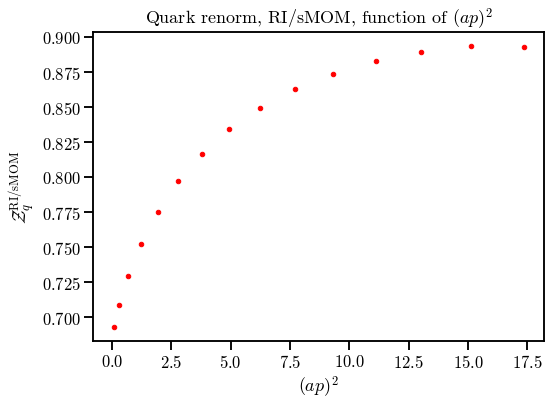

In [3]:
# Zq((ap)^2)
with sns.plotting_context('talk'):
    Zq_mu = np.mean(Zq, axis = 1)
    Zq_sigma = np.std(Zq, axis = 1, ddof = 1)
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, Zq_mu, Zq_sigma, fmt = '.', c = 'r')
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Quark renorm, RI/sMOM, function of $(ap)^2$')
    # plt.legend()
    plt.tight_layout()
    plt.show()

In [ ]:
# plt.savefig('/Users/theoares/Dropbox (MIT)/research/0nubb/writeups/figs_renorm/writeup_plots/Zq.pdf')

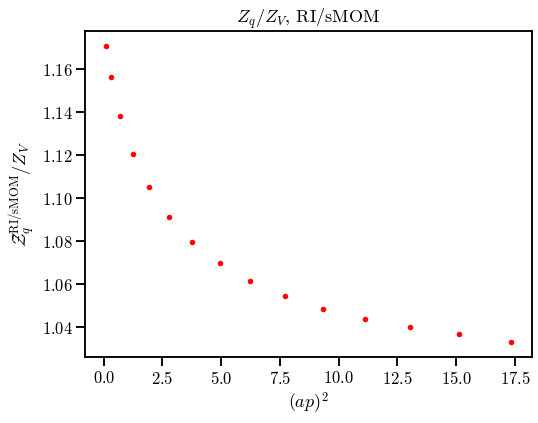

In [4]:
# Zq (μ^2)
ZqbyZV = Zq / ZV
ZqbyZV_mu = np.mean(ZqbyZV, axis = 1)
ZqbyZV_sigma = np.std(ZqbyZV, axis = 1, ddof = 1)
with sns.plotting_context('talk'):
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, ZqbyZV_mu, ZqbyZV_sigma, fmt = '.', c = 'r')
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}_q^\mathrm{RI/sMOM} / Z_V$', fontsize = 18)
    plt.title('$Z_q / Z_V$, RI/sMOM')
    plt.show()

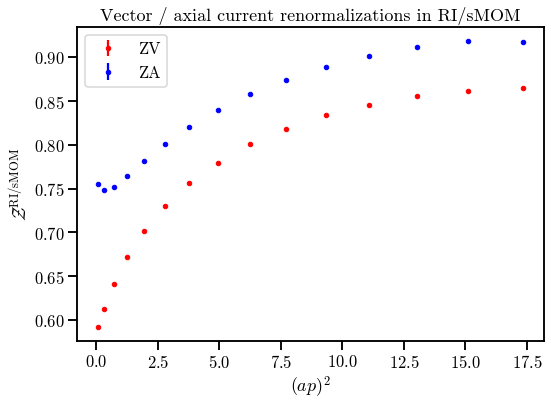

In [5]:
# ZV and ZA
ZV_mu = np.mean(ZV, axis = 1)
ZV_sigma = np.std(ZV, axis = 1, ddof = 1)
ZA_mu = np.mean(ZA, axis = 1)
ZA_sigma = np.std(ZA, axis = 1, ddof = 1)
with sns.plotting_context('talk'):
    plt.figure(figsize = (8, 6))
    plt.errorbar(apsq_list, ZV_mu, ZV_sigma, fmt = '.', c = 'r', label = 'ZV')
    plt.errorbar(apsq_list, ZA_mu, ZA_sigma, fmt = '.', c = 'b', label = 'ZA')
    # plt.ylim((0.6, 1.8))
    # plt.xlim((0, 5.5))
    plt.xlabel('$(ap)^2$', fontsize = 18)
    plt.ylabel('$\mathcal{Z}^\mathrm{RI/sMOM}$', fontsize = 18)
    plt.title('Vector / axial current renormalizations in RI/sMOM')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [6]:
def plot_RCs(x_list, labels, colors, ZVsq = False):
    plot_title = '$Z_{ij} / Z_V^2$ operator renormalization in RI/sMOM' if ZVsq else \
                        '$Z_{ij}$ operator renormalization in RI/sMOM'
    y_label = '$Z_{ij} / Z_V^2$' if ZVsq else '$Z_{ij}$'
    x_mu = [np.mean(x, axis = 1) for x in x_list]
    x_sigma = [np.std(x, axis = 1, ddof = 1) for x in x_list]
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10, 6))
        for ii in range(len(x_list)):
            plt.errorbar(apsq_list, x_mu[ii], x_sigma[ii], fmt = '.', c = colors[ii], \
                         label = labels[ii])
            plt.xlabel('$(ap)^2$', fontsize = 18)
            plt.ylabel(y_label, fontsize = 18)
            plt.title(plot_title)
        plt.legend(bbox_to_anchor=(1.1, 1.05))
        plt.tight_layout()
        plt.show()

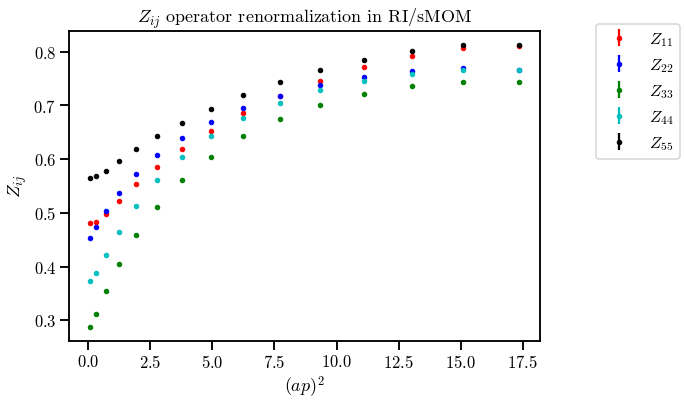

In [7]:
# Diagonal RCs
plot_RCs([Z[i, i] for i in range(5)], ['$Z_{'+str(i+1)+str(i+1) + '}$' for i in range(5)], ['r', 'b', 'g', 'c', 'k'])

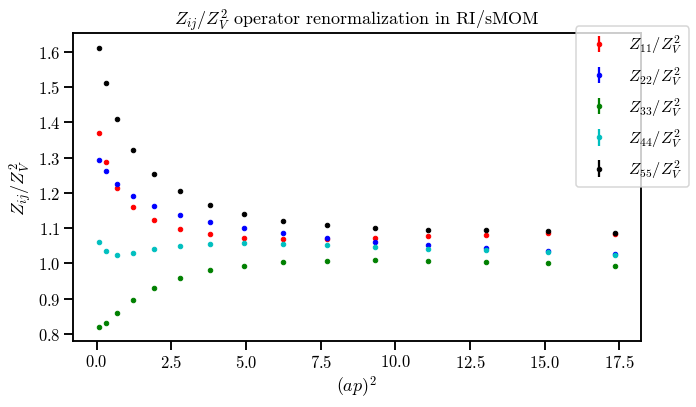

In [8]:
# Diagonal RCs / ZV^2
plot_RCs([ZbyZVsq[i, i] for i in range(5)], ['$Z_{' + str(i + 1) + str(i + 1) + '}/Z_V^2$' for i in range(5)], \
         ['r', 'b', 'g', 'c', 'k'], ZVsq = True)

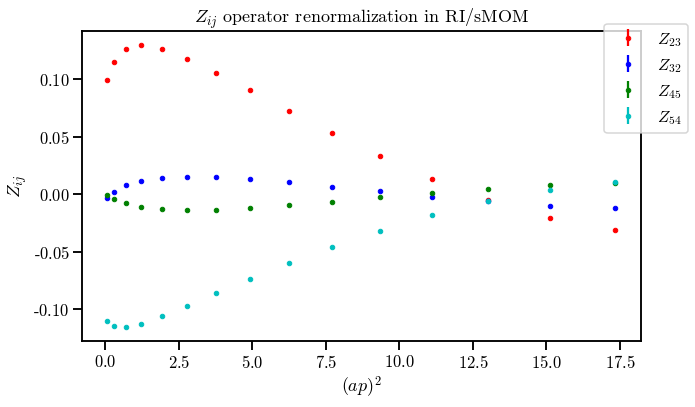

In [9]:
# Off diagonal elements allowed by chiral mixing
mix = [[1, 2], [2, 1], [3, 4], [4, 3]]
plot_RCs([Z[m[0], m[1]] for m in mix], ['$Z_{' + str(m[0] + 1) + str(m[1]+1)+'}$' for m in mix], ['r', 'b', 'g', 'c'])

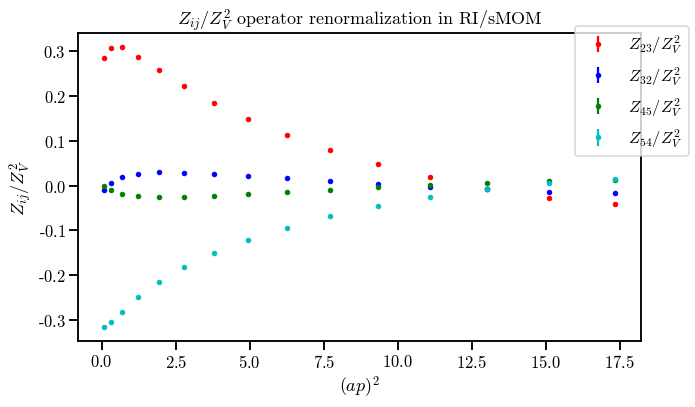

In [10]:
# Off diagonal elements allowed by chiral mixing
mix = [[1, 2], [2, 1], [3, 4], [4, 3]]
plot_RCs([ZbyZVsq[m[0], m[1]] for m in mix], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '} / Z_V^2$' for m in mix], \
         ['r', 'b', 'g', 'c'], ZVsq = True)

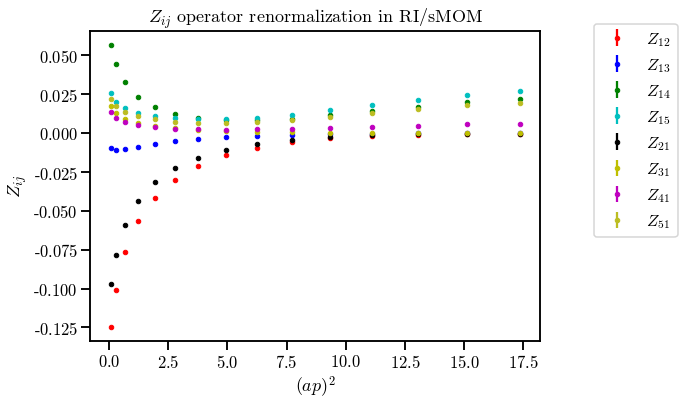

In [11]:
# Plot Zij for half the indices not allowed by chiral mixing
unmix1 = [[0, 1], [0, 2], [0, 3], [0, 4], [1, 0], [2, 0], [3, 0], [4, 0]]
plot_RCs([Z[m[0], m[1]] for m in unmix1], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '}$' for m in unmix1], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'])

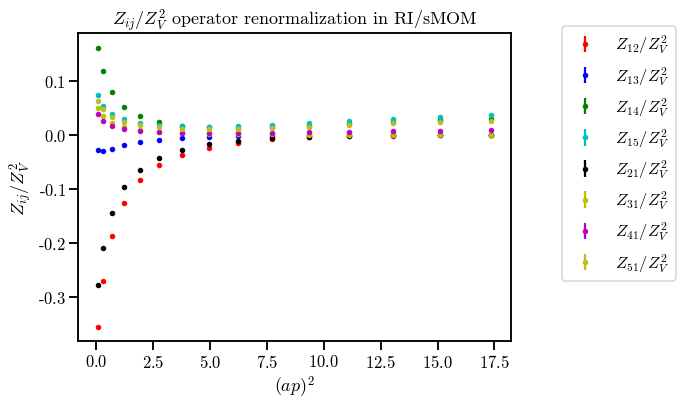

In [12]:
# Plot Zij / ZV^2 for half the indices not allowed by chiral mixing
plot_RCs([ZbyZVsq[m[0], m[1]] for m in unmix1], ['$Z_{' + str(m[0] + 1) + str(m[1]+1)+'} / Z_V^2$' for m in unmix1], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'], ZVsq = True)

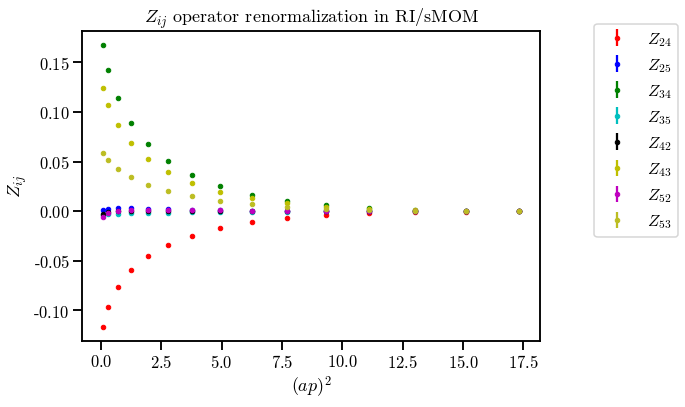

In [13]:
# Plot Zij for half the indices not allowed by chiral mixing
unmix2 = [[1, 3], [1, 4], [2, 3], [2, 4], [3, 1], [3, 2], [4, 1], [4, 2]]
plot_RCs([Z[m[0], m[1]] for m in unmix2], ['$Z_{' + str(m[0] + 1) + str(m[1] + 1) + '}$' for m in unmix2], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'])

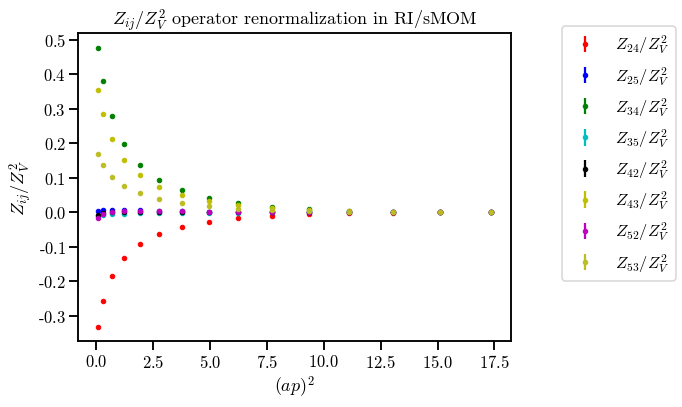

In [14]:
# Plot Zij / ZV^2 for half the indices not allowed by chiral mixing
plot_RCs([ZbyZVsq[m[0], m[1]] for m in unmix2], ['$Z_{' + str(m[0]+1)+str(m[1]+1) + '} / Z_V^2$' for m in unmix2], \
         ['r', 'b', 'g', 'c', 'k', 'y', 'm', 'tab:olive'], ZVsq = True)

## Find more RI/sMOM momenta

#### Look through spatial momenta

Conclusion: Momenta of the form $p_1 = (3n, 2n, 1n, 0)$ and $p_2 = (2n, -n, 3n, 0)$ will do the trick, but they have a smaller norm than the original choice of $(k, k, 0, 0)$, since the only valid momenta are when $3n < L / 2$, which has a maximum of $(15, 10, 5, 0)$. The same thing applies with momentum $p_1 = (2n, n, n, 0)$ and $p_2 = (n, -n, 2n, 0)$. 

In [ ]:
spatial_moms = []
for i, j, k in itertools.product(range(-3, 4), repeat = 3):
    spatial_moms.append([i, j, k, 0])
spatial_moms = np.array(spatial_moms)

In [ ]:
ϵ = 1e-5
all_p1, all_p2 = np.copy(spatial_moms), np.copy(spatial_moms)
for p1, p2 in itertools.product(all_p1, all_p2):
    q = p1 - p2
    if np.abs(norm(q) - norm(p1)) < ϵ and np.abs(norm(q) - norm(p2)) < ϵ:
        print('p1 = ' + str(p1) + '; p2 = ' + str(p2) + '; q = ' + str(q) + '; (ap)^2 = ' + str(norm(q)))

#### All (momenta, including time-like)

In [ ]:
all_kmodes = []
all_moms = []
# for i, j, k, l in itertools.product(range(-3, 4), repeat = 4):
for i, j, k, l in itertools.product(range(-4, 5), repeat = 4):
    wave_vec = np.array([i, j, k, l])
    all_kmodes.append(wave_vec)
    all_moms.append(Lat.to_linear_momentum(wave_vec))
all_kmodes = np.array(all_kmodes)
all_moms = np.array(all_moms)

In [ ]:
ϵ = 1e-5
for ii, jj in itertools.product(range(len(all_moms)), repeat = 2):
    p1, p2 = all_moms[ii], all_moms[jj]
    q = p1 - p2
    q_mode = all_kmodes[ii] - all_kmodes[jj]
    if np.abs(norm(q) - norm(p1)) < ϵ and np.abs(norm(q) - norm(p2)) < ϵ:
        print('k1 = ' + str(all_kmodes[ii]) + '; k2 = ' + str(all_kmodes[jj]) + '; q = ' + str(q_mode) \
              + '; (ap)^2 = ' + str(norm(q)))

In [ ]:
square(Lat.to_linear_momentum(np.array([15, 15, 0, 0])))

In [ ]:
square(Lat.to_linear_momentum(np.array([5, 10, 15, 0])))

Candidates (want to pick one with max momenta $\geq 17.3 = ||(15, 15, 0, 0) * 2\pi / L$||
- $k1 = [2 2 0 0]; k2 = [2 0 0 3]; q = [ 0  2  0 -3]; (ap)^2 = 0.5517987632906928$
    - Max momenta for $k_1 = [2n, 2n, 0, 0], k_2 = [2n, 0, 0, 3n]$ is $(ap)^2 = 15.1$
- (probably not) $k1 = [ 2  2  2 -3]; k2 = [2 2 2 3]; q = [ 0  0  0 -6]; (ap)^2 = 0.7803612947463989$
    - Max $(ap)^2 = 5.55$
- $k1 = [2 1 1 3]; k2 = [-1  1  2  3]; q = [ 3  0 -1  0]; (ap)^2 = 0.6175279103135096$
    - Max $(ap)^2 = 9.6$
- $k1 = [-1  3  2  0]; k2 = [-1  0  3 -3]; q = [ 0  3 -1  3]; (ap)^2 = 0.7346727144228068$
    - Max $(ap)^2 = 13.5$

## Fit $Z_q, Z_V, Z_A$

In [ ]:
lam_list = np.arange(0, 1, 0.1)
def fit_data_model(subset_idxs, Z, model, lam = 1):
    """
    Fits data Z to an arbitrary model by minimizing the correlated chi^2. 
    lam is the parameter for linear shrinkage, i.e. lam = 0 is the uncorrelated covariance, and lam = 1 is the 
    original covariance. 
    """
    fitter = BootstrapFitter(apsq_list[subset_idxs], np.einsum('kb->bk', Z[subset_idxs]), model)
    print('Original covariance: ' + str(fitter.covar))
    fitter.shrink_covar(lam)
    print('Shrunk covariance: ' + str(fitter.covar))
    fit_out = fitter.fit()
    print('Best fit coeffs: ' + str(fit_out[0]))
    print('chi^2 / dof: ' + str(fit_out[1] / fit_out[2]))
    return fit_out

def plot_fit_out(Z, fout, model, label, subset = list(range(len(apsq_list)))):
    #x_range = [0., 3.]
    buffer = 0.2    # extra space to add in plot
    x_range = [apsq_list[subset[0]] - buffer, apsq_list[subset[-1]] + buffer]
    x_fit_b = np.linspace(x_range[0], x_range[1])
    fx_fit_b = np.array([model.F(fout[0])(xb) for xb in x_fit_b], dtype = np.float64)
    Z_mu = np.mean(Z, axis = 1)
    Z_sigma = np.std(Z, axis = 1, ddof = 1)
    with sns.plotting_context('talk'):
        plt.figure(figsize = (10, 6))
        plt.errorbar(apsq_list, Z_mu, Z_sigma, c = 'b', fmt = '.')
        plt.plot(x_fit_b, fx_fit_b, c = 'r')
        plt.xlabel('$(ap)^2$')
        plt.ylabel(label)
        plt.title('Fits for ' + label)
        plt.show()

In [ ]:
# # Use a more arbitrary model
# subset_idxs = [2, 3, 4, 5, 6, 7]
# def model_ZV(params):
#     def model(apsq):
#         return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] * np.log(apsq)
#     return model
# m_ZV = Model(model_ZV, 4)
# ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0)
# plot_fitmodel_out(ZV, ZV_fout, m_ZV, label = '$Z_V$', subset = subset_idxs)

In [ ]:
# Use a more arbitrary model
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZV(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) * apsq
    return model
m_ZV = Model(model_ZV, 5)
ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0.5)
# ZV_fout = fit_data_model(subset_idxs, ZV, m_ZV, lam = 0.)
plot_fit_out(ZV, ZV_fout, m_ZV, label = '$Z_V$', subset = subset_idxs)

In [ ]:
# Use a more arbitrary model
# subset_idxs = [0, 1, 2, 3, 4, 5]
# def model_ZA(params):
#     def model(apsq):
#         return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq
#     return model
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZA(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * (apsq ** 3)
    return model
m_ZA = Model(model_ZA, 5)
ZA_fout = fit_data_model(subset_idxs, ZA, m_ZA, lam = 0.2)
plot_fit_out(ZA, ZA_fout, m_ZA, label = '$Z_A$', subset = subset_idxs)

In [ ]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Zq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * apsq * np.log(apsq)
    return model
m_Zq = Model(model_Zq, 6)
Zq_fout = fit_data_model(subset_idxs, Zq, m_Zq, lam = 0.)
plot_fit_out(Zq, Zq_fout, m_Zq, label = '$Z_q$', subset = subset_idxs)

In [ ]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_ZqZV(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3) #* apsq * np.log(apsq)
    return model
m_ZqZV = Model(model_ZqZV, 6)
ZqZV_fout = fit_data_model(subset_idxs, ZqbyZV, m_ZqZV, lam = 0.)
plot_fit_out(ZqbyZV, ZqZV_fout, m_ZqZV, label = '$Z_q / Z_V$', subset = subset_idxs)

## Fit $Z_{nm} / Z_V^2$

In [ ]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z11ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3)
    return model
m11ZVsq = Model(model_Z11ZVsq, 6)
Z11ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[0, 0], m11ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[0, 0], Z11ZVsq_fout, m11ZVsq, label = '$Z_{11} / Z_V^2$', subset = subset_idxs)

In [ ]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z22ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq ** 3)
    return model
m22ZVsq = Model(model_Z22ZVsq, 6)
Z22ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[1, 1], m22ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[1, 1], Z22ZVsq_fout, m22ZVsq, label = '$Z_{22} / Z_V^2$', subset = subset_idxs)

In [ ]:
subset_idxs = [0, 1, 2, 3, 4, 5, 6, 7]
def model_Z23ZVsq(params):
    def model(apsq):
        return params[0] * (apsq ** 0) + params[1] * (apsq ** 1) + params[2] * (apsq ** 2) + params[3] / apsq + params[4] * np.log(apsq) + params[5] * (apsq * np.log(apsq)) + params[6] * (apsq ** 3)
    return model
m23ZVsq = Model(model_Z23ZVsq, 7)
Z23ZVsq_fout = fit_data_model(subset_idxs, ZbyZVsq[1, 2], m23ZVsq, lam = 0.)
plot_fit_out(ZbyZVsq[1, 2], Z23ZVsq_fout, m23ZVsq, label = '$Z_{23} / Z_V^2$', subset = subset_idxs)

In [ ]:
# Shrinkage (linear vs nonlinear), thinning, SVD cuts
# cov = fitter.covar
# sigma = np.array([np.sqrt(cov[i, i]) for i in range(4)])
# corr = np.zeros((4, 4))
# for i, j in itertools.product(range(4), repeat = 2):
#     corr[i, j] = cov[i, j] / (sigma[i] * sigma[j])